In [74]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss

## From Scratch

In [3]:
def soft_thresholding(rho, lam):
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0

$$
\begin{align}
\rho_j &= \sum_{i=1}^N x_{ij} \times (y_j - \sum_{k\neq j} x_{ik}\beta_k) \\
&= \sum_{i=1}^N x_{ij} \times (y_j - \sum_{k=1}^p x_{ik}\beta_k + x_{ij}\beta_j) \\
&= \mathbf{x}_j^T (\mathbf{y} - \mathbf{X}\hat{\beta} + \hat{\beta}_j \mathbf{x}_j )
\end{align}
$$

In [20]:
def coordinate_descent(X, Y, beta, lam, num_iter=100):
    p = len(beta)
    
    for _ in range(num_iter):
        for j in range(p):
            rho_j = X[:, j].T * (Y - X * beta + beta[j,0] * X[:,j])
            beta[j,0] = soft_thresholding(rho_j, lam)

In [9]:
def center(X):
    return X - X.mean(axis=0)

def normalize(X):
    return X / np.linalg.norm(X, axis=0)

In [21]:
class OLSEstimator:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.y = np.asarray(self.Y).ravel()
        self.N = Y.shape[0]
        self.p = X.shape[1] - 1
        
    def estimate(self):
        self.beta_hat = np.linalg.pinv(self.X) * self.Y
        self.Y_hat = self.X * self.beta_hat
        self.y_hat = np.asarray(self.Y_hat).ravel()
        print("Estimate Success!")
        
    def test(self):
        self.rss = calc_rss(self.y, self.y_hat)
        self.sigma_hat = find_sigma_hat(self.y, self.y_hat, self.p)
        self.t_score = calc_t_score(np.asarray(self.beta_hat).ravel(), self.X, self.sigma_hat)
        
        t_dist = ss.t(df=self.N-self.p-1)
        
        p_fun = lambda t: calc_p_value(t_dist, t)
        p_vec = np.vectorize(p_fun)
        
        self.p_value = p_vec(self.t_score)
        
        print("Test Success!")
        
    def f_test(self, other): # self.f_test(other)
        if self.p >= other.p:
            rss_0 = other.rss
            rss_1 = self.rss
            p_0 = other.p
            p_1 = self.p
            N = self.N
            
            f_score = ((rss_0 - rss_1) / (p_1 - p_0)) / (rss_1 / (N - p_1 - 1))
            
            f_dist = ss.f(p_1-p_0, N - p_1 - 1)
            
            p_value = calc_p_value(f_dist, f_score)
            
            return (f_score, p_value)
        else:
            return other.f_test(self)
        
    def summary(self):
        print("N: ", self.N)
        print("p: ", self.p)
        print("beta: ", np.asarray(self.beta_hat).ravel())
        print("rss: ", self.rss)
        print("t_score: ", self.t_score)
        print("p_value: ", self.p_value)
    
    def plot(self):
        x = np.asarray(self.X[:, 1]).ravel()
        y = self.y
        y_hat = self.y_hat
        
        plt.figure(figsize=(10, 6), dpi=120)
        plt.scatter(x, y, label="data")
        plt.plot(x, y_hat, color='r', label="fit")
        plt.legend()
        plt.grid()
        plt.show()

In [53]:
def find_beta_hat(X, y, lam=0): # X should be np.matrix
    if lam == 0:
        return np.linalg.pinv(X) * y
    else:
        svd = np.linalg.svd(X, full_matrices=False)
        u, s, vt = svd
        u = np.matrix(u)
        vt = np.matrix(vt)
        s_star = np.matrix(np.diag(s / (s ** 2 + lam)))
        return (vt.T * s_star * u.T * y, svd)

def find_y_hat(X, beta):
    return X * beta

def standardize(x):
    return (x - x.mean(axis=0)) / x.std(axis=0)

def find_sigma_hat(y, y_hat, p):
    return np.sum((y - y_hat)**2) / (len(y) - p - 1)

def calc_t_score(beta, X, sigma):
    v = np.sqrt(np.diag(np.linalg.inv(X.T * X)))
    return (beta / v) / np.sqrt(sigma)

def calc_rss(y, y_hat):
    return np.sum((y - y_hat)**2)

def calc_F_score(rss_0, p_0, rss_1, p_1, N):
    return ((rss_0 - rss_1) / (p_1 - p_0)) / (rss_1 / (N - p_1 - 1))

def calc_p_value(d, z):
    if z >= 0:
        return (1 - d.cdf(z)) * 2
    else:
        return d.cdf(z) * 2

In [54]:
class RidgeReg(OLSEstimator):
    def __init__(self, X, Y, lam):
        self.X = standardize(X)
        self.Y = center(Y)
        self.beta_0 = np.mean(Y)
        self.lam = lam

    def estimate(self):
        self.beta_hat, self.svd = find_beta_hat(self.X, self.Y, self.lam)
        self.y_hat = find_y_hat(self.X, self.beta_hat)
        self.true_y_hat = self.y_hat + self.beta_0

    def test(self):
        self.N = self.Y.shape[0]
        self.p = self.X.shape[1]
        (u, s, vt) = self.svd
        s_star = np.matrix(np.diag(s / (s ** 2 + self.lam)))
        
        self.nu = self.N - self.p + np.sum((self.lam / (s ** 2 + self.lam)) ** 2)
        self.rss = calc_rss(np.asarray(self.Y).ravel(), np.asarray(self.y_hat).ravel())
        
        self.sigma_hat = self.rss / self.nu
        v = np.asarray((vt.T * s_star ** 2 * vt).diagonal()).ravel()
        self.t_score = np.asarray(self.beta_hat).ravel() / np.sqrt(self.sigma_hat * v)
        
        t_dist = ss.t(df=self.nu)

        p_fun = lambda t: calc_p_value(t_dist, t)
        p_fun = np.vectorize(p_fun)

        self.p_value = p_fun(self.t_score)

In [22]:
class Lasso:
    def __init__(self, X, Y, lam, num_iter=100):
        self.X = normalize(center(X))
        self.Y = center(Y)
        self.beta_0 = Y.mean(axis=0)
        self.lam = lam
        self.num_iter = num_iter
        self.p = self.X.shape[1]
        
    def estimate(self):
        self.beta = np.ones((self.p, 1))
        coordinate_descent(self.X, self.Y, self.beta, self.lam, self.num_iter)
        self.y_hat = self.X * self.beta + self.beta_0

### Example

In [104]:
x = np.arange(0, np.pi, 0.01)
y = np.sin(x) + (x / 3)**2 + np.random.randn(len(x)) * 0.1

X = np.matrix(np.column_stack([x**2, x**3, x**4, np.sin(x)]))
Y = np.matrix(y).T

Xb = sm.add_constant(X)

# OLS
ols = OLSEstimator(Xb, Y)
ols.estimate()

# Ridge
ridge = RidgeReg(X, Y, 0.1)
ridge.estimate()

# Lasso
lasso = Lasso(X, Y, 0.1)
lasso.estimate()

Estimate Success!


In [88]:
ridge.test()
ridge.summary()

N:  315
p:  6
beta:  [ 0.26803157  0.09856922 -0.009334   -0.03322051  0.01402687  0.31923675]
rss:  3.355437974784416
t_score:  [ 3.06135439  1.92254943 -0.10193    -0.70905706  0.15860379 21.21409699]
p_value:  [0.00239551 0.05544937 0.91887789 0.47882    0.87408393 0.        ]


In [89]:
lasso.beta

array([[5.83493829],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [5.3992312 ]])

In [90]:
ridge.beta_hat

matrix([[ 0.26803157],
        [ 0.09856922],
        [-0.009334  ],
        [-0.03322051],
        [ 0.01402687],
        [ 0.31923675]])

In [91]:
ols.beta_hat

matrix([[-0.00588191],
        [ 0.28636974],
        [-0.24757914],
        [ 0.15341485],
        [-0.04534262],
        [ 0.00511878],
        [ 0.96334196]])

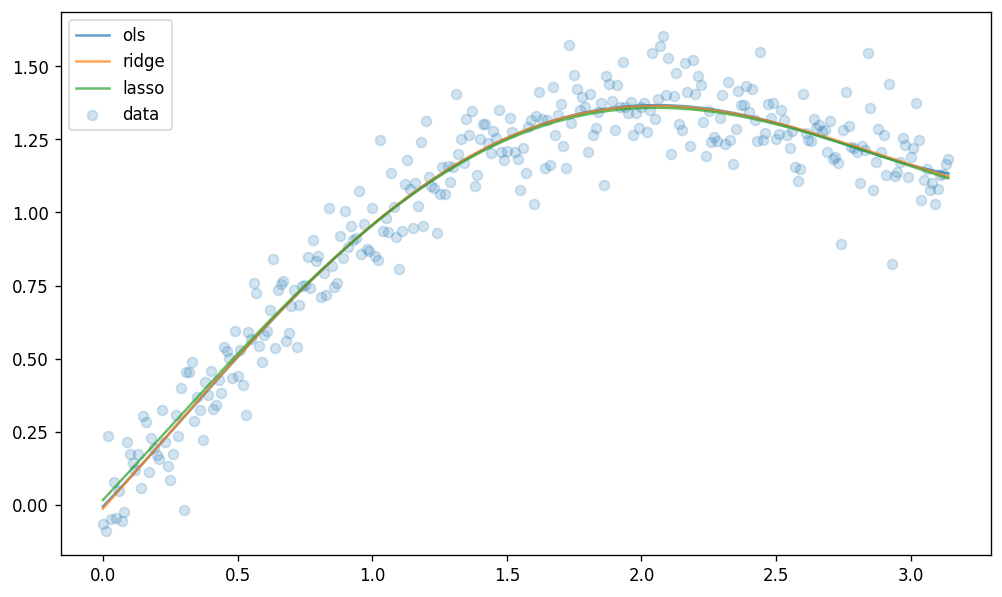

In [92]:
plt.figure(figsize=(10,6), dpi=120)
plt.scatter(x, y, alpha=0.2, label="data")
plt.plot(x, ols.y_hat, alpha=0.7, label="ols")
plt.plot(x, ridge.true_y_hat, alpha=0.7, label="ridge")
plt.plot(x, lasso.y_hat, alpha=0.7, label="lasso")
plt.legend()
plt.show()

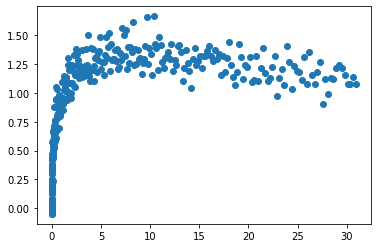

In [105]:
plt.scatter(np.asarray(X[:,1]).ravel(), np.asarray(Y).ravel())

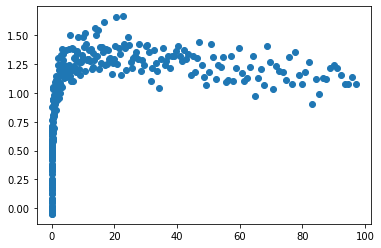

In [106]:
plt.scatter(np.asarray(X[:,2]).ravel(), np.asarray(Y).ravel())

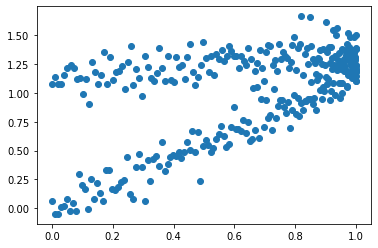

In [107]:
plt.scatter(np.asarray(X[:,3]).ravel(), np.asarray(Y).ravel())

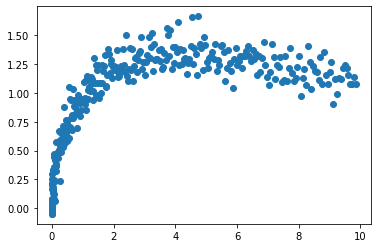

In [108]:
plt.scatter(np.asarray(X[:,0]).ravel(), np.asarray(Y).ravel())

In [109]:
np.cov(np.asarray(X[:,0]).ravel(), np.asarray(Y).ravel())

array([[8.72723033, 0.72475542],
       [0.72475542, 0.15846467]])

In [110]:
np.cov(np.asarray(X[:,1]).ravel(), np.asarray(Y).ravel())

array([[77.97672383,  1.74349748],
       [ 1.74349748,  0.15846467]])

In [111]:
np.cov(np.asarray(X[:,2]).ravel(), np.asarray(Y).ravel())

array([[6.82283387e+02, 4.27533276e+00],
       [4.27533276e+00, 1.58464665e-01]])

In [112]:
np.cov(np.asarray(X[:,3]).ravel(), np.asarray(Y).ravel())

array([[0.09584959, 0.06960582],
       [0.06960582, 0.15846467]])

In [113]:
svd = np.linalg.svd(X, full_matrices=False)

In [115]:
u, s, vt = svd

In [116]:
v = vt.T

In [126]:
z0 = X * v[:,0]

In [128]:
[abs(np.dot(z0.T, X[:,i]) / (np.sqrt(np.dot(z0.T, z0)) * np.sqrt(np.dot(X[:,i].T, X[:,i])))) for i in range(4)]

[matrix([[0.96342593]]),
 matrix([[0.99430884]]),
 matrix([[0.9998269]]),
 matrix([[0.38677003]])]